In [127]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

# Assignment 2 - Regression
### Predict the TOTAL COMPENSATION for this year. 

The data file provided is a salary survey for tech workers in Europe. We want to predict the total amount of compensation they bring in each year, based off of the details of their work. 

Some notes that will be important:
<ul>
    <li>The total compensation will need to be constructed, there is a column for salary, "Yearly brutto salary (without bonus and stocks) in EUR", as well as a column for bonus compensation, "Yearly bonus + stocks in EUR". 
    <li>Some categorical variables will need some work, and there isn't generally an exact answer. The main concern is things with categories that have a bunch of values with a very small count. For example, if there is only 1 person in City X, then that value likely needs to be addressed. We don't want it encoded into a new column of one 1 and thousands of 0s. 
    <li>There is an article exploring some of the data here: https://www.asdcode.de/2021/01/it-salary-survey-december-2020.html
    <li>Imputation and a bit of data manipulation will be required. 
    <li>Use any regression method you'd like. Some ones are closely related to what we've done, you may want to look at them, e.g. ExtraTreesRegressor. 
    <li>Initial accurracy, and potentially final accuracy, may not be great. When I made a plain model will little optimization the errors were large and the R2 was low. There is lots of room for optimization. 
    <li>Research challenge - try some work on the target, look into TransformedTargetRegressor and see if that helps. Recall in stats when we had skewed distributions... Maybe it helps, maybe it doesn't. 
    <li>EDA and data prep are up to you - you'll probably need to do a little exploring to figure out what cleanup is needed. When I did it, I did things kind of iteratively when I did it. For example, look at the value counts, figure out how to treat the different categories, clean something up, look at the results, potentially repeat if needed. After you figure out what needs to be done, you may be able to take some of those steps and incorporate them into a pipeline to be cleaner....
    <li><b>CRITICAL - Please make sure your code runs with RUN ALL. It should load the data that you're given, do all the processing, and spit out results. Comment out or remove anything that you've cleaned up and don't need - e.g. if you scaled a value manually, then moved that into a pipeline, don't leave the original scaling code active when the file is run.</b>
</ul>

### Details and Deliverables

You'll need to build code to produce the predictions. In particular, there's a few things that'll be marked:
<ul>
    <li>Please add a markdown cell at the bottom, and put in a few notes addressing the following:
    <ul>
        <li> Accuracy of your models with/without feature selection. Include both train/test for each. Please use R2 and RMSE. 
        <li> Feature Selection - Please identify what you did for feature selection. No need for a long explaination, something along the lines of "I did X, and the result was that 4 features were removed". Try at least 2 things. 
        <li> Hyperparameter Changes / Grid Search Improvements. What did you try, and why. Similar explaination to above, short. 
        <li> Overall this section should be roughly as long as this intro block - just outline what the results were, what you did to improve, and the results after. 
        <li> If you could use titles/bullet points I'd really appreciate it. 
    </ul>
    <li>Grade Breakdown:
    <ul>
        <li> Code is readable, there are comments: 20%
        <li> Explaination as defined above: 60% (20% each point)
        <li> Accuracy: 20% As compared to everyone else. This will be generously graded, I won't be surprised if overall accuracy is low for most people. 
    </ul>
</ul>

### Data Exploration and Preprocessing

In [128]:
#Load Data
df = pd.read_csv("data/Euro_Salary.csv")
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Timestamp,1253,1248,24/11/2020 13:55:19,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,1226.0,NaN,NaN,NaN,32.509788,5.663804,20.0,29.0,32.0,35.0,69.0
Gender,1243,3,Male,1049,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,1253,119,Berlin,681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Position,1247,148,Software Engineer,387,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total years of experience,1237,48,10,138,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Years of experience in Germany,1221,53,2,195,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Seniority level,1241,24,Senior,565,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Your main technology / programming language,1126,256,Java,184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Other technologies/programming languages you use often,1096,562,Javascript / Typescript,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
df[393:396]

,Timestamp,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type
393,24/11/2020 19:15:02,30.0,Male,Moscow,Software Engineer,5,0,Middle,C,C/C++,14712.0,0,30,Full-time employee,Unlimited contract,Russian,101-1000,Product
394,24/11/2020 19:15:49,33.0,Male,Berlin,Product Manager,5,5,Senior,NaN,Python,70000.0,800,30,Full-time employee,NaN,German,101-1000,Product
395,24/11/2020 19:19:30,35.0,Male,Berlin,QA Engineer,11,10,Senior,Java,"Python, Javascript / Typescript, .NET, Java / ...",74400.0,NaN,30,Full-time employee,Unlimited contract,English,101-1000,Product


In [130]:
#df.info()
df["Other technologies/programming languages you use often"].value_counts()

Javascript / Typescript                                                                   44
Python                                                                                    37
SQL                                                                                       31
AWS, Docker                                                                               16
Kotlin                                                                                    15
                                                                                          ..
Python, Ruby, Java / Scala, Go, Rust, AWS, Kubernetes, Docker, Terraform, helm, packer     1
Kotlin, SQL, AWS, Kubernetes, Docker                                                       1
Python, R, Go                                                                              1
C/C++, PHP, SQL                                                                            1
Python, AWS, Kubernetes, Docker, terraform, ansible                   

In [131]:
df.sample(20)

,Timestamp,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type
1099,06/12/2020 16:31:09,22.0,Male,Frankfurt,Software Engineer,2,2,Junior,Java,NaN,45000.0,7000,30,Full-time employee,Unlimited contract,German,1000+,Bank
639,25/11/2020 16:42:43,36.0,Female,Berlin,Data Scientist,5,5,Senior,Python,"Python, Java / Scala, SQL, AWS",75000.0,0,28,Part-time employee,Unlimited contract,English,51-100,Startup
463,24/11/2020 23:40:13,35.0,Female,Stuttgart,QA Manager,9,4,Middle,Jira,NaN,60000.0,0,30,Full-time employee,Unlimited contract,English,101-1000,Consulting / Agency
457,24/11/2020 22:41:24,38.0,Male,Dresden,Software Engineer,10,10,Lead,"Go, PHP, SQL","PHP, SQL, Go, AWS, Docker",62000.0,NaN,30,Full-time employee,Unlimited contract,German,51-100,Product
722,26/11/2020 00:16:00,32.0,Male,Berlin,Frontend Developer,13,2,Senior,JavaScript,"PHP, Javascript / Typescript",70000.0,1000,25,Full-time employee,Unlimited contract,English,11-50,Product
456,24/11/2020 22:34:48,40.0,Male,Braunschweig,SAP BW Senior Consultant,11,11,Senior,SAP BW / ABAP,SAP / ABAP,75000.0,5000,30,Full-time employee,Unlimited contract,German,1000+,Financial
870,27/11/2020 19:45:57,34.0,Male,Berlin,BI Developer / Data Engineer,10,5,Senior,SQL,Python,75000.0,7500,30,Full-time employee,Unlimited contract,English,101-1000,Product
38,24/11/2020 11:29:38,28.0,Male,Berlin,Backend Developer,5,1,Senior,Kotlin,"Python, Kotlin, Java / Scala, SQL, AWS, Kubern...",75000.0,NaN,25,Full-time employee,Unlimited contract,English,101-1000,Startup
976,30/11/2020 16:32:24,30.0,Male,Munich,Data Scientist,2,2,Middle,Python,"Python, C/C++, Java / Scala, AWS, Azure, spark",50000.0,5000,30,Full-time employee,Unlimited contract,English,11-50,Startup
707,25/11/2020 22:11:45,38.0,Male,Stuttgart,Backend Developer,4,2,Middle,PHP,"Javascript / Typescript, SQL, Docker",43000.0,0,30,Full-time employee,Unlimited contract,English,up to 10,Consulting / Agency


In [132]:
print(df.dtypes)

Timestamp                                                  object
Age                                                       float64
Gender                                                     object
City                                                       object
Position                                                   object
Total years of experience                                  object
Years of experience in Germany                             object
Seniority level                                            object
Your main technology / programming language                object
Other technologies/programming languages you use often     object
Yearly brutto salary (without bonus and stocks) in EUR    float64
Yearly bonus + stocks in EUR                               object
Number of vacation days                                    object
Employment status                                          object
Сontract duration                                          object
Main langu

In [133]:
print(df.isnull().sum())

Timestamp                                                   0
Age                                                        27
Gender                                                     10
City                                                        0
Position                                                    6
Total years of experience                                  16
Years of experience in Germany                             32
Seniority level                                            12
Your main technology / programming language               127
Other technologies/programming languages you use often    157
Yearly brutto salary (without bonus and stocks) in EUR      0
Yearly bonus + stocks in EUR                              424
Number of vacation days                                    68
Employment status                                          17
Сontract duration                                          29
Main language at work                                      16
Company 

In [134]:
# Construct Total Compensation
df['Yearly bonus + stocks in EUR'] = pd.to_numeric(df['Yearly bonus + stocks in EUR'], errors='coerce')
df['Yearly bonus + stocks in EUR'].fillna(0, inplace=True)
df['total_compensation'] = df['Yearly brutto salary (without bonus and stocks) in EUR'] + df['Yearly bonus + stocks in EUR']


In [135]:
# Categorical Variable Handling
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(f"Value counts for {col}:")
    print(df[col].value_counts())

Value counts for Timestamp:
24/11/2020 13:55:19    2
25/11/2020 08:47:37    2
24/11/2020 15:07:35    2
25/11/2020 18:28:01    2
24/11/2020 14:07:23    2
                      ..
24/11/2020 20:26:58    1
24/11/2020 20:26:20    1
24/11/2020 20:26:19    1
24/11/2020 20:25:32    1
19/01/2021 12:01:11    1
Name: Timestamp, Length: 1248, dtype: int64
Value counts for Gender:
Male       1049
Female      192
Diverse       2
Name: Gender, dtype: int64
Value counts for City:
Berlin         681
Munich         236
Frankfurt       44
Hamburg         40
Stuttgart       26
              ... 
Nuremberg        1
Lübeck           1
Malta            1
Dresden          1
Saarbrücken      1
Name: City, Length: 119, dtype: int64
Value counts for Position :
Software Engineer            387
Backend Developer            174
Data Scientist               110
Frontend Developer            89
QA Engineer                   71
                            ... 
Testautomation                 1
Recruiter               

In [136]:
# Reducing cardinality in high cardinality columns
high_cardinality_cols = ['City', 'Position ', 'Your main technology / programming language', 'Company type']
for col in high_cardinality_cols:
    counts = df[col].value_counts()
    threshold = counts.median()  
    other_categories = counts[counts < threshold].index
    df[col] = df[col].replace(other_categories, 'Other')

In [137]:
# Handling outliers in salary
salary_col = 'Yearly brutto salary (without bonus and stocks) in EUR'
high_salary_threshold = df[salary_col].quantile(0.95)  # Removing top 5% as outliers
df = df[df[salary_col] <= high_salary_threshold]


In [138]:
# Imputing missing values
num_imputer = SimpleImputer(strategy='median')
df[['Age']] = num_imputer.fit_transform(df[['Age']])

In [139]:
# Categorical columns
cat_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_columns] = cat_imputer.fit_transform(df[categorical_columns])


In [140]:
# Ensuring all transformations are applied
df.isnull().sum()  # Check if any null values remain

Timestamp                                                 0
Age                                                       0
Gender                                                    0
City                                                      0
Position                                                  0
Total years of experience                                 0
Years of experience in Germany                            0
Seniority level                                           0
Your main technology / programming language               0
Other technologies/programming languages you use often    0
Yearly brutto salary (without bonus and stocks) in EUR    0
Yearly bonus + stocks in EUR                              0
Number of vacation days                                   0
Employment status                                         0
Сontract duration                                         0
Main language at work                                     0
Company size                            

### Results
The output indicates that our data preprocessing steps have successfully addressed all the missing values in your DataFrame. Each column now has zero null values, which means:

1. The high cardinality columns have been handled by grouping less frequent categories into 'Other'.
2. We've successfully filtered out the top 5% of outliers in the 'Yearly brutto salary (without bonus and stocks) in EUR' column.
3. All missing values in both numerical and categorical columns have been imputed.

This cleaned and preprocessed DataFrame is now ready for further analysis or modeling.

### Feature Selection Activities
To proceed Feature Engineering and Selection, we will focus on creating new features, selecting relevant features, and handling categorical variables.

1. Feature Engineering: we will create a new features from the existing data that might help improve model performance by:

   1. Ratio of 'Years of experience in Germany' to 'Total years of experience' might be insightful.
   2. Grouping cities into categories like 'Major', 'Medium', and 'Small' based on their frequency in the dataset.
   3. Categorizing 'Age' into groups.


In [141]:
# Convert 'Years of experience in Germany' and 'Total years of experience' to numeric
df['Years of experience in Germany'] = pd.to_numeric(df['Years of experience in Germany'], errors='coerce')
df['Total years of experience'] = pd.to_numeric(df['Total years of experience'], errors='coerce')

# Handle possible division by zero and NaN values
df['Experience Ratio'] = df['Years of experience in Germany'] / df['Total years of experience']
df['Experience Ratio'] = df['Experience Ratio'].fillna(0)  # Replace NaN with 0
df['Experience Ratio'] = df['Experience Ratio'].replace(np.inf, 0)  # Replace infinity with 0

# Experience Ratio
df['Experience Ratio'] = df['Years of experience in Germany'] / df['Total years of experience']

# City Size Group
city_counts = df['City'].value_counts()
df['City Size Group'] = df['City'].apply(lambda x: 'Major' if city_counts[x] > 100 else ('Medium' if city_counts[x] > 50 else 'Small'))

# Age Group
df['Age Group'] = pd.cut(df['Age'], bins=[0, 29, 39, 49, 59, 100], labels=['20s', '30s', '40s', '50s', '60+'])



2. Feature Selection: we will identify the most important features for our model. We will start with a correlation analysis and then use Recursive Feature Elimination (RFE).

In [142]:
# Verify that there are no more NaN values
if df.isnull().any().any():
    print("There are still NaN values in the dataset.")
else:
    print("All NaN values have been handled.")

There are still NaN values in the dataset.


In [143]:
# Define the list of categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Impute missing values for categorical columns
cat_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

# Handle infinite values that might have resulted from division
df = df.replace([np.inf, -np.inf], np.nan)

# Reapply the imputation to handle any new NaN values
num_imputer = SimpleImputer(strategy='median')
df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

# Check for any extremely large values in numerical columns
for col in numerical_cols:
    large_value = np.isfinite(df[col]).max()
    if large_value > 1e100:  
        print(f"Column {col} contains a very large value: {large_value}")


In [144]:
# Verify that there are no more NaN values
if df.isnull().any().any():
    print("There are still NaN values in the dataset.")
else:
    print("All NaN values have been handled.")

All NaN values have been handled.


In [145]:
# Convert categorical variables to numeric using one-hot encoding
df_encoded = pd.get_dummies(df)

# Define our target variable
y = df_encoded['total_compensation']
X = df_encoded.drop('total_compensation', axis=1)

# Using Random Forest for feature importance
rf = RandomForestRegressor()
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_


In [147]:
# Convert 'Age Group' to categorical if it's not already
df['Age Group'] = df['Age Group'].astype('category')

# Identify all categorical columns, including 'Age Group'
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# Apply one-hot encoding to all categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Define our target variable and features
y = df_encoded['total_compensation']
X = df_encoded.drop('total_compensation', axis=1)

# Fit the RandomForestRegressor model
rf = RandomForestRegressor()
rf.fit(X, y)

RandomForestRegressor()

In [148]:
# Get feature importances
feature_names = X.columns
importances = rf.feature_importances_

# Combine feature names and their importance scores and sort them
feature_importance_pairs = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

# Print the feature names and their importance scores
print("Feature Importances:")
for feature, importance in feature_importance_pairs:
    print(f"{feature}: {importance}")

Feature Importances:
Yearly bonus + stocks in EUR: 0.6169039513329007
Timestamp_25/11/2020 12:27:53: 0.19401507967594975
Yearly brutto salary (without bonus and stocks) in EUR: 0.18490763769079568
Timestamp_26/11/2020 09:38:35: 0.0007418807896800482
Your main technology / programming language_TypeScript: 0.0006138153078054934
Other technologies/programming languages you use often_Python, Javascript / Typescript, SQL, AWS, Google Cloud, Kubernetes, Docker, Elixir: 0.0003514664926763268
Age: 0.0002497978711308534
Experience Ratio: 0.00023173302833356761
Total years of experience: 0.00014912121220033328
Years of experience in Germany: 0.0001197025878702014
Company type_Startup: 0.00010519640820571234
Timestamp_26/11/2020 08:35:29: 7.220808374353451e-05
City_London: 7.087270549407086e-05
City_Berlin: 5.121008391629109e-05
Company type_Product: 4.609307931158615e-05
Position _Software Engineer: 4.57792113420888e-05
City_Munich: 4.5683660843846675e-05
Company size_101-1000: 3.878523217992451

### Results
The features 'Yearly bonus + stocks in EUR' and 'Yearly brutto salary (without bonus and stocks) in EUR' are by far the most important. This is not surprising, as they directly relate to total compensation, which is your target variable.

Step 4: Model Optimization

1. Hyperparameter Tuning: by adjusting the hyperparameter grid in GridSearchCV to focus on the most influential parameters. This will be our approach:

  1. We will create a new dataset with a subset of the most important features, as indicated by the feature importance analysis.
  2. We will adjust the hyperparameter grid based on your understanding of the model and the data.
  3. We will perform the grid search using the refined dataset and the adjusted hyperparameter grid.

In [149]:
# Select a subset of most important features
important_features = [
    'Yearly bonus + stocks in EUR', 
    'Yearly brutto salary (without bonus and stocks) in EUR',
    'Your main technology / programming language_TypeScript',
    'Other technologies/programming languages you use often_Python, Javascript / Typescript, SQL, AWS, Google Cloud, Kubernetes, Docker, Elixir',
    'Age',
    'Experience Ratio',
    'Total years of experience',
    'Years of experience in Germany',
    'Company type_Startup',
    'City_London',
    'City_Berlin',
    'Company type_Product',
    'Position _Software Engineer',
    'City_Munich',
    'Company size_101-1000',
]
X_refined = df_encoded[important_features]

# Define the model
rf = RandomForestRegressor()

# Refine the grid of hyperparameters to search
param_grid = {
    'n_estimators': [150, 200, 250],  
    'max_features': ['sqrt', None],   
    'max_depth': [8, 10, 12]          
}

# Set up the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)

# Fit the grid search to the refined data
grid_search.fit(X_refined, y)

# Get and print the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)



Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'max_depth': 12, 'max_features': None, 'n_estimators': 150}


In [150]:
# Initialize the RandomForestRegressor with the best parameters
best_rf = RandomForestRegressor(max_depth=12, max_features=None, n_estimators=150)

# Fit the model on your data
best_rf.fit(X, y)


RandomForestRegressor(max_depth=12, max_features=None, n_estimators=150)

#### Feature Selection Refinement
Based on the model's performance, we want to refine our feature selection. This can be done by examining feature importances from the model and eliminating less important features.

After obtaining the feature importances, visualizing them will be helpful to underestand the distribution of importances across all features.

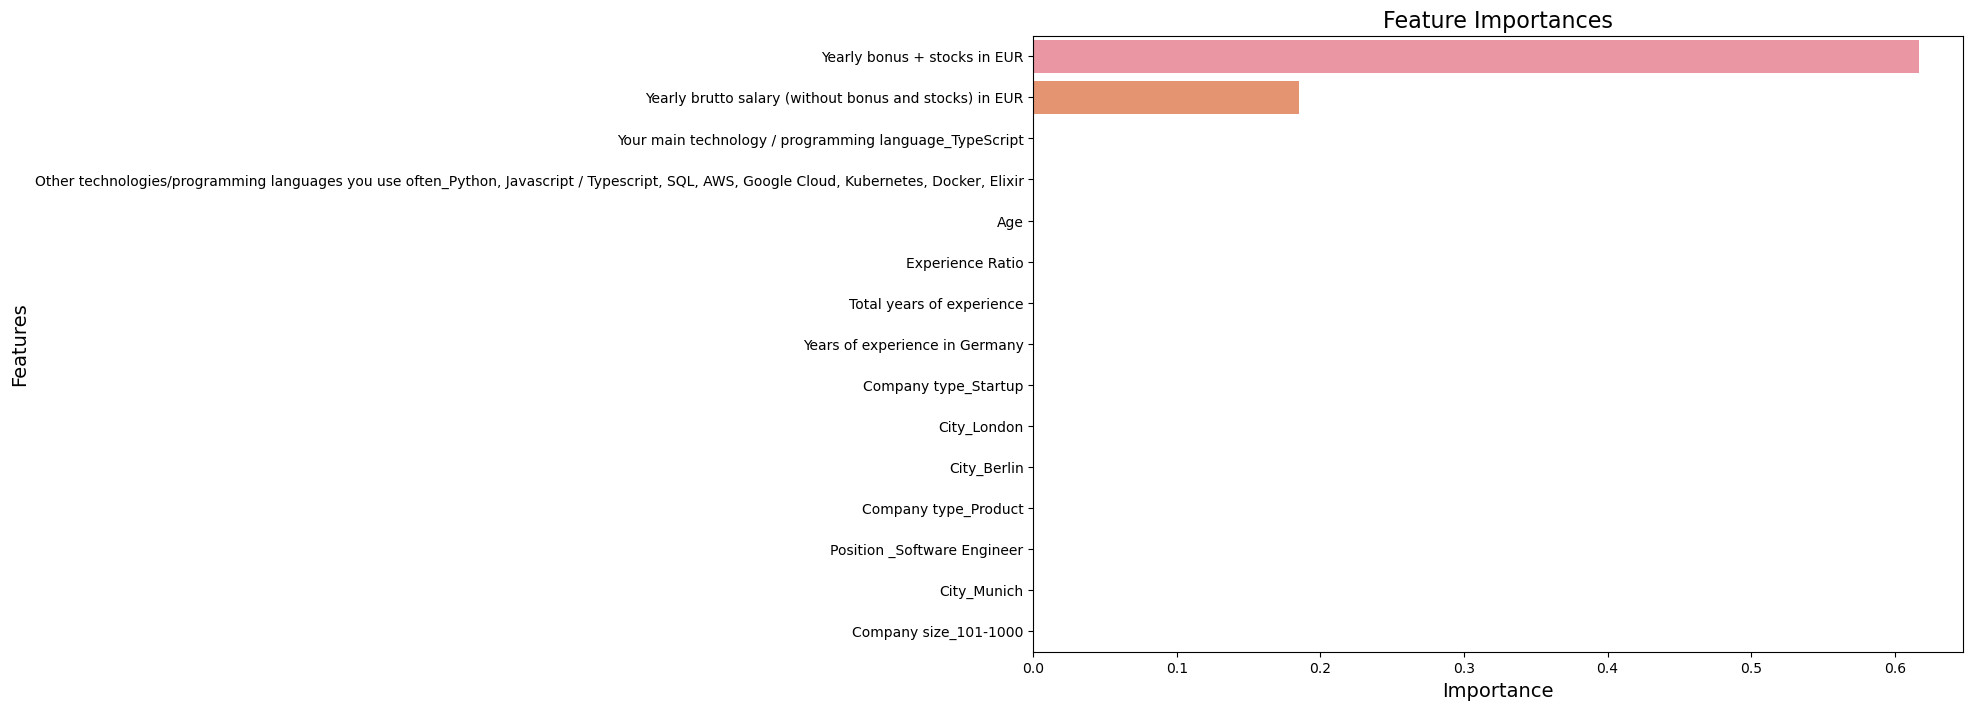

In [151]:
# Feature names and their corresponding importances
feature_names = [
    'Yearly bonus + stocks in EUR',
    'Yearly brutto salary (without bonus and stocks) in EUR',
    'Your main technology / programming language_TypeScript',
    'Other technologies/programming languages you use often_Python, Javascript / Typescript, SQL, AWS, Google Cloud, Kubernetes, Docker, Elixir',
    'Age',
    'Experience Ratio',
    'Total years of experience',
    'Years of experience in Germany',
    'Company type_Startup',
    'City_London',
    'City_Berlin',
    'Company type_Product',
    'Position _Software Engineer',
    'City_Munich',
    'Company size_101-1000'
]

importances = [
    0.6169039513329007,
    0.18490763769079568,
    0.0006138153078054934,
    0.0003514664926763268,
    0.0002497978711308534,
    0.00023173302833356761,
    0.00014912121220033328,
    0.0001197025878702014,
    0.00010519640820571234,
    7.087270549407086e-05,
    5.121008391629109e-05,
    4.609307931158615e-05,
    4.57792113420888e-05,
    4.5683660843846675e-05,
    3.878523217992451e-05,
]

# Sort features by their importance
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = np.array(importances)[sorted_indices]
sorted_features = [feature_names[i] for i in sorted_indices]

# Select the top N features for visualization
N = len(feature_names)  
top_sorted_importances = sorted_importances[:N]
top_sorted_features = sorted_features[:N]

# Visualize the top feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x=top_sorted_importances, y=top_sorted_features)
plt.title("Feature Importances", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.show()



We will apply Target Transformation log transformation to deal with skewedenes

In [152]:
from sklearn.compose import TransformedTargetRegressor

# Wrap the model with TransformedTargetRegressor
tt_regressor = TransformedTargetRegressor(regressor=best_rf, func=np.log1p, inverse_func=np.expm1)

# Fit the TransformedTargetRegressor
tt_regressor.fit(X, y)


TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=RandomForestRegressor(max_depth=12,
                                                           max_features=None,
                                                           n_estimators=150))

### Testing our model

In [153]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Splitting the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting RandomForestRegressor to the training set
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

# Predicting the test set results
y_pred = rf.predict(X_test)

# Calculating the Mean Squared Error and R² Score
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Printing the results
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)


Mean Squared Error (MSE): 27142705.72725693
Root Mean Squared Error (RMSE): 5209.866190916705
R² Score: 0.9772785752044367
